# Time series forecasting: Traditional Methods vs TimeGPT

The goal of this project is to conduct a forecasting task on weekly sales data and compare the performances of linear regression, 
exponential smoothing, ARIMA and TimeGPT

### Import the relevant packages

In [153]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.api import ExponentialSmoothing as HWES
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from dotenv import load_dotenv, find_dotenv
from nixtla import NixtlaClient
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings("ignore")

### Inspect the dataset

In [154]:
df = pd.read_csv("sales.csv")

In [155]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10244 entries, 0 to 10243
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         10244 non-null  int64  
 1   Dept          10244 non-null  int64  
 2   Date          10244 non-null  object 
 3   IsHoliday     10244 non-null  bool   
 4   Weekly_Sales  10244 non-null  float64
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 330.3+ KB


In [156]:
df.head()

,Store,Dept,Date,IsHoliday,Weekly_Sales
0,1,1,05/02/2010,False,25355.470154
1,1,1,12/02/2010,True,45620.932761
2,1,1,19/02/2010,False,43678.320935
3,1,1,26/02/2010,False,19192.020491
4,1,1,05/03/2010,False,21563.677300


#### check if there are any missing values 

In [157]:
df.isnull().sum().sort_values(ascending=False)

Store           0
Dept            0
Date            0
IsHoliday       0
Weekly_Sales    0
dtype: int64

#### change the date column datatype from object to date type

In [158]:
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

### Get an idea of the distributions of the variables

In [159]:
df["Date"].describe()

count                            10244
mean     2011-06-16 19:25:27.996876544
min                2010-02-05 00:00:00
25%                2010-10-08 00:00:00
50%                2011-06-17 00:00:00
75%                2012-02-24 00:00:00
max                2012-10-26 00:00:00
Name: Date, dtype: object

In [160]:
#check the number of departments within the store
df["Dept"].unique

<bound method Series.unique of 0         1
1         1
2         1
3         1
4         1
         ..
10239    99
10240    99
10241    99
10242    99
10243    99
Name: Dept, Length: 10244, dtype: int64>

In [161]:
#check what is the percentage of holiday and non-holidays dates in the data
print("the percentage of holidays dates in the data is: ", sum(df["IsHoliday"] == True)/len(df))
print("the percentage of non holidays dates in the data is: ", sum(df["IsHoliday"] == False)/len(df))

the percentage of holidays dates in the data is:  0.0705778992581023
the percentage of non holidays dates in the data is:  0.9294221007418977


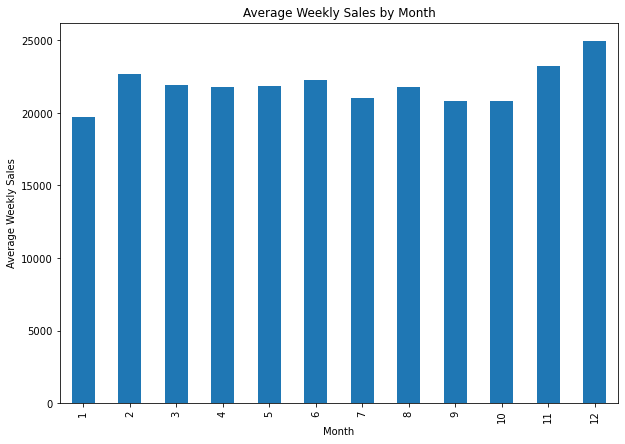

In [162]:
#analyze average weekly sales by months
month = df.Date.dt.month
plt.figure(figsize=(10, 7))
df.groupby(month).Weekly_Sales.mean().plot.bar()
plt.xlabel('Month')
plt.ylabel('Average Weekly Sales')
plt.title('Average Weekly Sales by Month')
plt.show()

### Group the dataframe by date to observe the total sales in the store

In [163]:
#group the dataframe by date to observe the total sales in the store
df = df.groupby(['Date', 'IsHoliday'], as_index=False)['Weekly_Sales'].sum()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          143 non-null    datetime64[ns]
 1   IsHoliday     143 non-null    bool          
 2   Weekly_Sales  143 non-null    float64       
dtypes: bool(1), datetime64[ns](1), float64(1)
memory usage: 2.5 KB


In [164]:
df.head()

,Date,IsHoliday,Weekly_Sales
0,2010-02-05,False,1.654088e+06
1,2010-02-12,True,1.650933e+06
2,2010-02-19,False,1.628874e+06
3,2010-02-26,False,1.429147e+06
4,2010-03-05,False,1.563790e+06


### Visualize the data

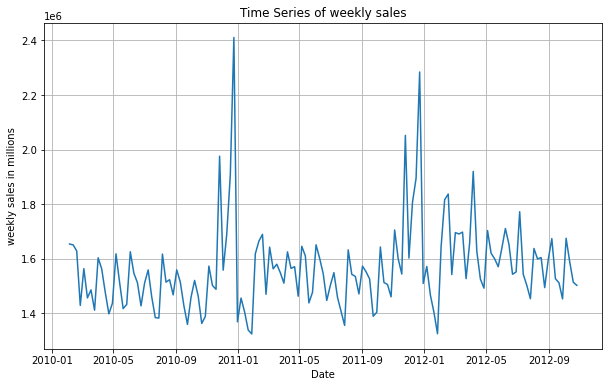

In [165]:
plt.figure(figsize=(10, 6))
plt.plot(df['Date'].values, df['Weekly_Sales'].values, linestyle='-')
plt.title('Time Series of weekly sales')
plt.xlabel('Date')
plt.ylabel('weekly sales in millions')
plt.grid(True)
plt.show()

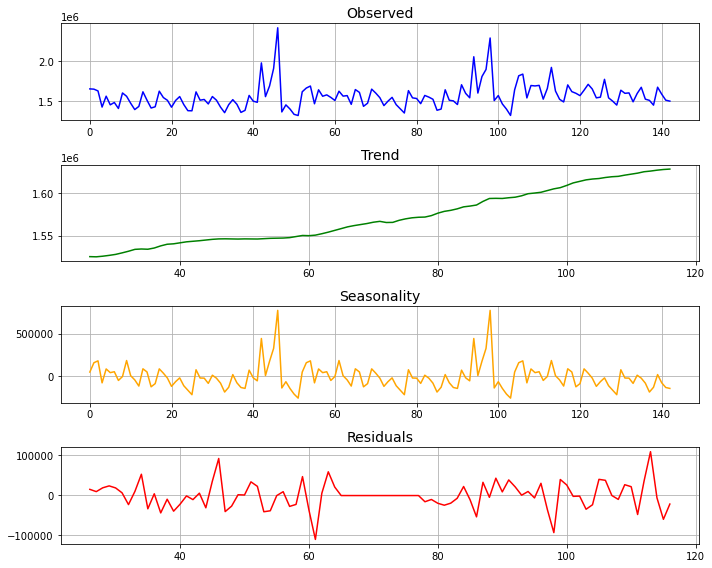

In [166]:
# Split the time series in its components
decomposition = seasonal_decompose(df['Weekly_Sales'], model='additive', period = 52)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8))

#observed
ax1.plot(decomposition.observed, label='Observed', color='blue')
ax1.set_title('Observed', fontsize=14)
ax1.grid(True)

#trend 
ax2.plot(decomposition.trend, label='Trend', color='green')
ax2.set_title('Trend', fontsize=14)
ax2.grid(True)

#seasonality
ax3.plot(decomposition.seasonal, label='Seasonality', color='orange')
ax3.set_title('Seasonality', fontsize=14)
ax3.grid(True)

# Residuals
ax4.plot(decomposition.resid, label='Residuals', color='red')
ax4.set_title('Residuals', fontsize=14)
ax4.grid(True)

plt.tight_layout()
plt.show()

### Test for stationarity

#### Dickey Fueller test

In [167]:
stationarity= adfuller(df["Weekly_Sales"].values)
print("Test statistic is:", stationarity[0])
print("p-value is:", stationarity[1])

Test statistic is: -5.106312213743748
p-value is: 1.3615015238232047e-05


Since the p-value is greater than 0.05 we cannot reject the null hypothesis and the series is considered to be non stationary.

### Split the data for modelling

In [105]:
train = df[:int(0.75 * len(df))]
train.shape

(107, 3)

In [106]:
test = df[int(0.75 * len(df)):]
test.shape

(36, 3)

### Baseline model

In [107]:
mean_value = train["Weekly_Sales"].mean()

# Create an array with this value repeated 43 times
baseline = np.full(len(test), mean_value)
baseline

array([1554669.10767828, 1554669.10767828, 1554669.10767828,
       1554669.10767828, 1554669.10767828, 1554669.10767828,
       1554669.10767828, 1554669.10767828, 1554669.10767828,
       1554669.10767828, 1554669.10767828, 1554669.10767828,
       1554669.10767828, 1554669.10767828, 1554669.10767828,
       1554669.10767828, 1554669.10767828, 1554669.10767828,
       1554669.10767828, 1554669.10767828, 1554669.10767828,
       1554669.10767828, 1554669.10767828, 1554669.10767828,
       1554669.10767828, 1554669.10767828, 1554669.10767828,
       1554669.10767828, 1554669.10767828, 1554669.10767828,
       1554669.10767828, 1554669.10767828, 1554669.10767828,
       1554669.10767828, 1554669.10767828, 1554669.10767828])

### Linear Regression

In [108]:
train_x = train.drop(["Date", "Weekly_Sales"], axis = 1)
train_y = train.set_index('Date')[['Weekly_Sales']]

In [126]:
test_x = test.drop(["Date", "Weekly_Sales"], axis = 1)
test_y = test["Weekly_Sales"]

In [127]:
model = LinearRegression()
model.fit(train_x, train_y)

# Get predictions
lr_predictions = model.predict(test_x)

In [128]:
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)
r2 = r2_score(test_y, lr_predictions)
print("R-squared:", r2)

Coefficients: [[135049.04771434]]
Intercept: [1543309.84198268]
R-squared: -0.3043427390488944


In [129]:
lr_predictions

array([[1543309.84198268],
       [1543309.84198268],
       [1543309.84198268],
       [1543309.84198268],
       [1543309.84198268],
       [1543309.84198268],
       [1543309.84198268],
       [1543309.84198268],
       [1543309.84198268],
       [1543309.84198268],
       [1543309.84198268],
       [1543309.84198268],
       [1543309.84198268],
       [1543309.84198268],
       [1543309.84198268],
       [1543309.84198268],
       [1543309.84198268],
       [1543309.84198268],
       [1543309.84198268],
       [1543309.84198268],
       [1543309.84198268],
       [1543309.84198268],
       [1543309.84198268],
       [1543309.84198268],
       [1543309.84198268],
       [1543309.84198268],
       [1543309.84198268],
       [1543309.84198268],
       [1678358.88969702],
       [1543309.84198268],
       [1543309.84198268],
       [1543309.84198268],
       [1543309.84198268],
       [1543309.84198268],
       [1543309.84198268],
       [1543309.84198268]])

### Exponential smoothing

Since the data shows both trend and seasonality, I will use the Holt-Winters method.

In [130]:
train_y = train.set_index('Date')[['Weekly_Sales']]

In [131]:
model = HWES(train_y, seasonal_periods=52, trend='add', seasonal='add')
hw1 = model.fit()

In [132]:
holt_winters_forecasts = hw1.forecast(steps=len(test))

In [133]:
holt_winters_forecasts

2012-02-24    1.543673e+06
2012-03-02    1.717500e+06
2012-03-09    1.638623e+06
2012-03-16    1.655530e+06
2012-03-23    1.624140e+06
2012-03-30    1.587634e+06
2012-04-06    1.702845e+06
2012-04-13    1.641546e+06
2012-04-20    1.647437e+06
2012-04-27    1.538308e+06
2012-05-04    1.720446e+06
2012-05-11    1.684512e+06
2012-05-18    1.511803e+06
2012-05-25    1.550379e+06
2012-06-01    1.724559e+06
2012-06-08    1.675190e+06
2012-06-15    1.618705e+06
2012-06-22    1.523180e+06
2012-06-29    1.579557e+06
2012-07-06    1.624881e+06
2012-07-13    1.534083e+06
2012-07-20    1.481929e+06
2012-07-27    1.431542e+06
2012-08-03    1.740370e+06
2012-08-10    1.638899e+06
2012-08-17    1.648398e+06
2012-08-24    1.593110e+06
2012-08-31    1.684699e+06
2012-09-07    1.639029e+06
2012-09-14    1.552382e+06
2012-09-21    1.482633e+06
2012-09-28    1.582731e+06
2012-10-05    1.646019e+06
2012-10-12    1.588918e+06
2012-10-19    1.486877e+06
2012-10-26    1.511518e+06
Freq: W-FRI, dtype: float64

### ARIMA Model

In [150]:
model = auto_arima(train_y, seasonal=True, m=52, trace=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[52] intercept   : AIC=2847.216, Time=5.50 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=2886.603, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=2863.108, Time=0.90 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=2857.414, Time=0.49 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=3357.894, Time=0.02 sec
 ARIMA(2,0,2)(0,0,1)[52] intercept   : AIC=2856.059, Time=4.74 sec
 ARIMA(2,0,2)(1,0,0)[52] intercept   : AIC=2846.308, Time=3.14 sec
 ARIMA(2,0,2)(0,0,0)[52] intercept   : AIC=2882.604, Time=0.21 sec
 ARIMA(2,0,2)(2,0,0)[52] intercept   : AIC=2848.102, Time=26.44 sec
 ARIMA(2,0,2)(2,0,1)[52] intercept   : AIC=2851.954, Time=38.26 sec
 ARIMA(1,0,2)(1,0,0)[52] intercept   : AIC=2848.989, Time=2.66 sec
 ARIMA(2,0,1)(1,0,0)[52] intercept   : AIC=2849.976, Time=4.79 sec
 ARIMA(3,0,2)(1,0,0)[52] intercept   : AIC=2847.329, Time=6.28 sec
 ARIMA(2,0,3)(1,0,0)[52] intercept   : AIC=2852.780, Time=3.96 sec
 ARIMA(1,0,1)(1,0

In [152]:
ARIMA = model.predict(n_periods= len(test))
ARIMA

2012-02-24    1.548144e+06
2012-03-02    1.600793e+06
2012-03-09    1.553889e+06
2012-03-16    1.573041e+06
2012-03-23    1.547266e+06
2012-03-30    1.526383e+06
2012-04-06    1.596895e+06
2012-04-13    1.559070e+06
2012-04-20    1.563298e+06
2012-04-27    1.496021e+06
2012-05-04    1.609525e+06
2012-05-11    1.587851e+06
2012-05-18    1.480864e+06
2012-05-25    1.504842e+06
2012-06-01    1.612868e+06
2012-06-08    1.582460e+06
2012-06-15    1.547292e+06
2012-06-22    1.486451e+06
2012-06-29    1.520760e+06
2012-07-06    1.549660e+06
2012-07-13    1.493646e+06
2012-07-20    1.461302e+06
2012-07-27    1.429685e+06
2012-08-03    1.601474e+06
2012-08-10    1.545869e+06
2012-08-17    1.540968e+06
2012-08-24    1.501259e+06
2012-08-31    1.564410e+06
2012-09-07    1.551590e+06
2012-09-14    1.535032e+06
2012-09-21    1.450550e+06
2012-09-28    1.459609e+06
2012-10-05    1.607939e+06
2012-10-12    1.527316e+06
2012-10-19    1.522669e+06
2012-10-26    1.494712e+06
Freq: W-FRI, dtype: float64

### TimeGPT

In [134]:
_ = load_dotenv(find_dotenv("api.env"))
nixtla_key  = os.environ['Nixtla_API_KEY']

In [135]:
timegpt = NixtlaClient(
    api_key = nixtla_key
)

In [136]:
timegpt.validate_api_key()

INFO:nixtla.nixtla_client:Happy Forecasting! :), If you have questions or need support, please email ops@nixtla.io


True

In [141]:
test_x = test.drop("Weekly_Sales", axis = 1)

In [140]:
timegpt_preds = []

for i in range(0, len(test), 9):

    timegpt_preds_df = timegpt.forecast(
        df = df[: len(train) + i],
        X_df = test_x[i:i+9],
        h= 9,
        finetune_steps=20,
        freq = "W-FRI",
        time_col='Date',
        target_col='Weekly_Sales'
    )
    
    preds = timegpt_preds_df['TimeGPT']
    
    timegpt_preds.extend(preds)

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using the following exogenous variables: IsHoliday
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using the following exogenous variables: IsHoliday
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using the following exogenous variables: IsHoliday
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using the following exogenous variables: IsHoliday
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


In [146]:
timegpt_preds

[1615198.342762986,
 1642005.717762986,
 1670775.342762986,
 1621472.217762986,
 1504331.327137986,
 1521263.686512986,
 1608085.092762986,
 1620992.905262986,
 1575125.577137986,
 1588862.801996139,
 1629009.958246139,
 1630517.958246139,
 1616927.958246139,
 1599284.239496139,
 1668349.958246139,
 1671716.020746139,
 1628683.958246139,
 1562892.692621139,
 1549386.8297648756,
 1560665.7985148756,
 1542443.0953898756,
 1513684.8922648756,
 1505114.8297648756,
 1552626.5797648756,
 1581017.1891398756,
 1570419.1578898756,
 1544398.4391398756,
 1537296.6377085382,
 1557882.2314585382,
 1552809.9502085382,
 1503423.2939585382,
 1509506.2627085382,
 1596904.4814585382,
 1599777.2939585382,
 1595217.6377085382,
 1577498.7783335382]

### Visualize the forecasting by different methods

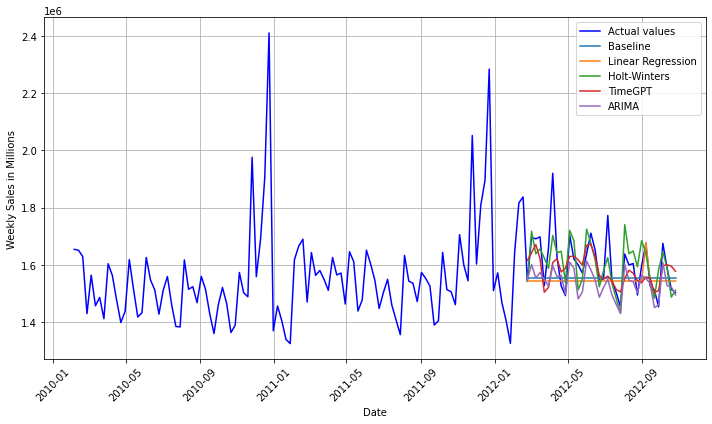

In [147]:
dates = df["Date"].values

models_predictions = {
    "Baseline": baseline, 
    "Linear Regression": lr_predictions,
    "Holt-Winters": holt_winters_forecasts.values,
    "TimeGPT": timegpt_preds,
    "ARIMA": ARIMA.values
}

#plotting
plt.figure(figsize=(10, 6))
plt.plot(dates, df["Weekly_Sales"].values, label="Actual values", color='blue')

for model, preds in models_predictions.items():
    plt.plot(test["Date"].values, preds, label=model)

plt.xlabel("Date")
plt.ylabel("Weekly Sales in Millions")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

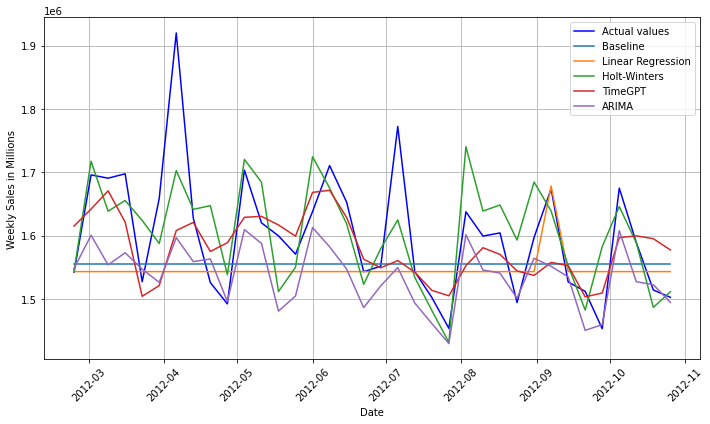

In [148]:
dates =  test["Date"].values

plt.figure(figsize=(10, 6))
plt.plot(dates, test["Weekly_Sales"].values, label="Actual values", color='blue')

for model, preds in models_predictions.items():
    plt.plot(dates, preds, label=model)

plt.xlabel("Date")
plt.ylabel("Weekly Sales in Millions")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()


### Evaluating the models

In [149]:
results = []
for model_name, predictions in models_predictions.items():
    mse = mean_squared_error(test_y, predictions, squared=False)
    results.append({"Model Name": model_name, "MSE": mse})


results_df = pd.DataFrame(results).sort_values(by="MSE", ascending=True)
results_df.reset_index(drop=True)

,Model Name,MSE
0,Holt-Winters,71228.213866
1,TimeGPT,83553.818812
2,ARIMA,94807.485280
3,Baseline,106518.386222
4,Linear Regression,109754.940738
